# Testing Seaborn

In [36]:

import polars as pl
import seaborn as sns

In [37]:
sns.set_theme()

tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


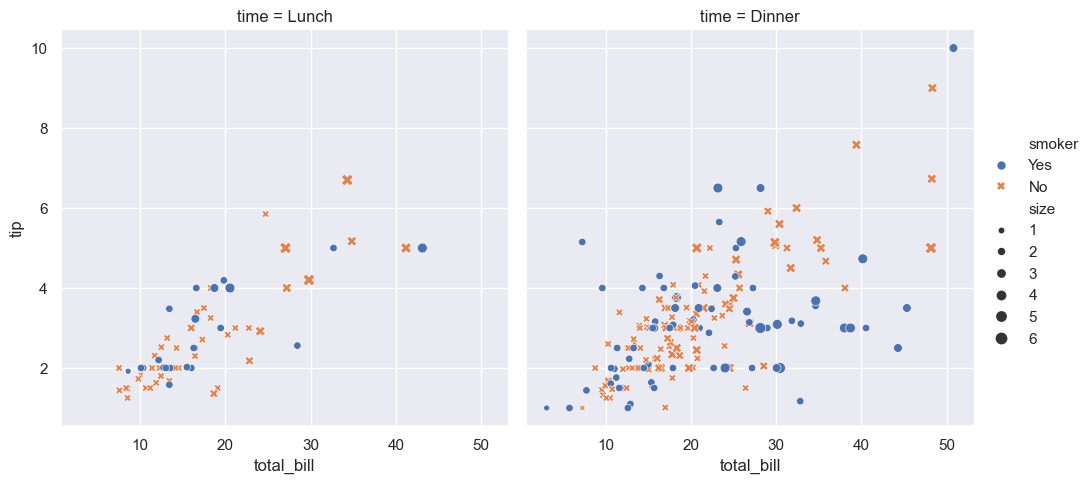

In [38]:
sns.relplot(
  data=tips,
  x="total_bill",
  y="tip",
  col="time",
  hue="smoker",
  style="smoker",
  size="size"
)

<Axes: >

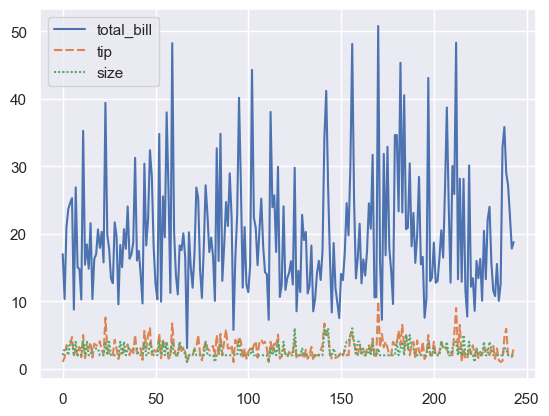

In [39]:
sns.lineplot(data=tips, )

In [40]:
import pandas as pa
import numpy as np
from pandas import DataFrame

In [41]:
# Config for saving outputs
SAVE_ENABLED = True
SERIAL_NUMBER = "NOT_SET"

# Model parameters
SEQ_LEN = 30
HORIZON = 1
BATCH_SIZE = 256
NUM_EPOCHS = 20
HIDDEN_SIZE = 128
N_LAYERS = 2
DROPOUT = 0.3
N_LAGS = 5
N_DYADS = 5000

# Train parameters
TARGET = "gravity_trade_change"
FEATURES = [
  "GDP_reporter",
  "GDP_partner",
  "distw",
  "gravity_trade",
  "arms", "military", "trade", "financial", "travel", "other",  # sanctions categorical
  "contig", "comlang_off", "colony", "smctry",  # dist cepii categorical
  "fyear", "GDP_yearly_average"  # additional features
]
N_SPLITS = 3
PATIENCE = 15
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.01
RANDOM_SEED = 16
KEEP_FRAC = 0.1

EPS = 1e-19

SANCTION_COLS = ["arms", "military", "trade", "travel", "other"]

In [42]:
processed = pa.read_parquet(path="../../data/model/processed.parquet", engine="fastparquet")
df: DataFrame = processed.copy(deep=True)

In [43]:
# Sort data by Report + Partner + Year
df["dyad_id"] = df["ISO3_reporter"] + "_" + df["ISO3_partner"]
df = df.sort_values(by=["dyad_id", "Year"]).reset_index(drop=True)

In [44]:
# dyad_subsample = pa.Series(df["dyad_id"].unique()).sample(n=N_DYADS, random_state=RANDOM_SEED, replace=False)
# df = df[df["dyad_id"].isin(dyad_subsample)]
print(len(df["dyad_id"]))

1178547


In [45]:
df["gravity_trade"] = np.log1p((df["GDP_reporter"] * df["GDP_partner"]) / df["distw"])
df["GDP_reporter"] = np.log1p(df["GDP_reporter"]).astype(float)
df["GDP_partner"] = np.log1p(df["GDP_partner"]).astype(float)
df["TOTAL"] = df["IMPORT"] + df["EXPORT"]
df["EXPORT"] = np.log1p(df["EXPORT"])
df["sanction"] = (df[SANCTION_COLS]
                  .sum(axis=1)).astype(int)
df["distw"] = np.log1p(df["distw"]).astype(float)

In [46]:
num_cols = ["gravity_trade", "distw", "GDP_reporter", "GDP_partner", "sanction", "contig",
            "comlang_off", "colony", "smctry", "Year", "GDP_yearly_average"]
df[num_cols] = df[num_cols].apply(pa.to_numeric, errors="coerce").astype(float)
df = df.dropna(subset=num_cols)
years = sorted(df["Year"].unique())[1:-1]

In [47]:
lag_cols = ["GDP_reporter", "GDP_partner", "sanction", ]
invariant_cols = ["contig", "comlang_off", "colony", "smctry", "distw"]
df["EXPORT_lag1"] = df.groupby("dyad_id")["EXPORT"].shift(1)

for col in lag_cols:
  for index in range(1, N_LAGS + 1):
    df[f"{col}_lag{index}"] = df.groupby("dyad_id")[col].shift(-index)
df = df.dropna()
df["Year"] = df["Year"].astype(int)
for col in ["dyad_id"]:
  df[col] = pa.Categorical(df[col], categories=sorted(df[col].unique()))


In [49]:
df.dtypes

ISO3_reporter           object
UNDS_reporter           object
CNAME_reporter          object
ISO3_partner            object
UNDS_partner            object
CNAME_partner           object
Year                     int64
GDP_reporter           float64
GDP_partner            float64
contig                 float64
comlang_off            float64
comlang_ethno             bool
colony                 float64
smctry                 float64
distcap                float64
distw                  float64
IMPORT                 float64
EXPORT                 float64
arms                   float64
military               float64
trade                  float64
descr_trade             object
financial              float64
travel                 float64
other                  float64
target_mult            float64
sender_mult            float64
GDP_yearly_average     float64
dyad_id               category
gravity_trade          float64
TOTAL                  float64
sanction               float64
EXPORT_l

In [59]:
pl_df = pl.DataFrame({
  "dyad_id": df["dyad_id"],  # take entire Series
  "Year": df["Year"]
})
pl_df = pl_df.to_dummies(columns=["dyad_id"], drop_first=True)
pl_df

dyad_id_AGO_AND,dyad_id_AGO_ARE,dyad_id_AGO_ARG,dyad_id_AGO_ARM,dyad_id_AGO_ATG,dyad_id_AGO_AUS,dyad_id_AGO_AUT,dyad_id_AGO_AZE,dyad_id_AGO_BDI,dyad_id_AGO_BEL,dyad_id_AGO_BEN,dyad_id_AGO_BFA,dyad_id_AGO_BGD,dyad_id_AGO_BGR,dyad_id_AGO_BHR,dyad_id_AGO_BHS,dyad_id_AGO_BIH,dyad_id_AGO_BLR,dyad_id_AGO_BLZ,dyad_id_AGO_BOL,dyad_id_AGO_BRA,dyad_id_AGO_BRB,dyad_id_AGO_BRN,dyad_id_AGO_BTN,dyad_id_AGO_BWA,dyad_id_AGO_CAF,dyad_id_AGO_CAN,dyad_id_AGO_CHE,dyad_id_AGO_CHL,dyad_id_AGO_CHN,dyad_id_AGO_CIV,dyad_id_AGO_CMR,dyad_id_AGO_COL,dyad_id_AGO_COM,dyad_id_AGO_CPV,dyad_id_AGO_CRI,dyad_id_AGO_CUB,…,dyad_id_ZWE_SLE,dyad_id_ZWE_SLV,dyad_id_ZWE_SMR,dyad_id_ZWE_SOM,dyad_id_ZWE_STP,dyad_id_ZWE_SUR,dyad_id_ZWE_SVK,dyad_id_ZWE_SVN,dyad_id_ZWE_SWE,dyad_id_ZWE_SWZ,dyad_id_ZWE_SYC,dyad_id_ZWE_SYR,dyad_id_ZWE_TCD,dyad_id_ZWE_TGO,dyad_id_ZWE_THA,dyad_id_ZWE_TJK,dyad_id_ZWE_TKM,dyad_id_ZWE_TON,dyad_id_ZWE_TTO,dyad_id_ZWE_TUN,dyad_id_ZWE_TUR,dyad_id_ZWE_TUV,dyad_id_ZWE_TZA,dyad_id_ZWE_UGA,dyad_id_ZWE_UKR,dyad_id_ZWE_URY,dyad_id_ZWE_USA,dyad_id_ZWE_UZB,dyad_id_ZWE_VCT,dyad_id_ZWE_VEN,dyad_id_ZWE_VNM,dyad_id_ZWE_VUT,dyad_id_ZWE_WSM,dyad_id_ZWE_YEM,dyad_id_ZWE_ZAF,dyad_id_ZWE_ZMB,Year
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,…,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i64
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1989
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1990
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1991
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1992
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1993
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2013
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2014
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015
